In [97]:
pip install torchinfo

Looking in indexes: http://rep.msk.mts.ru/artifactory/api/pypi/pypi/simple
ERROR: Could not find a version that satisfies the requirement torchinfo (from versions: none)
ERROR: No matching distribution found for torchinfo
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import cv2
import albumentations as A
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import torch.nn as nn
from torch.nn.functional import log_softmax
from torchvision import models
from nltk import edit_distance
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pytorch_lightning as pl
import os
# from torchinfo import summary

import plotly.io as pio
import plotly.express as px
pio.renderers
pio.renderers.default = "png"

In [2]:
RANDOM_STATE = 666

### EDA

In [3]:
train_df = pd.read_csv('dataset/train_labels.csv')
train_df.head()

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз
2,3.jpg,ходят
3,4.jpg,"ощущений,"
4,5.jpg,74


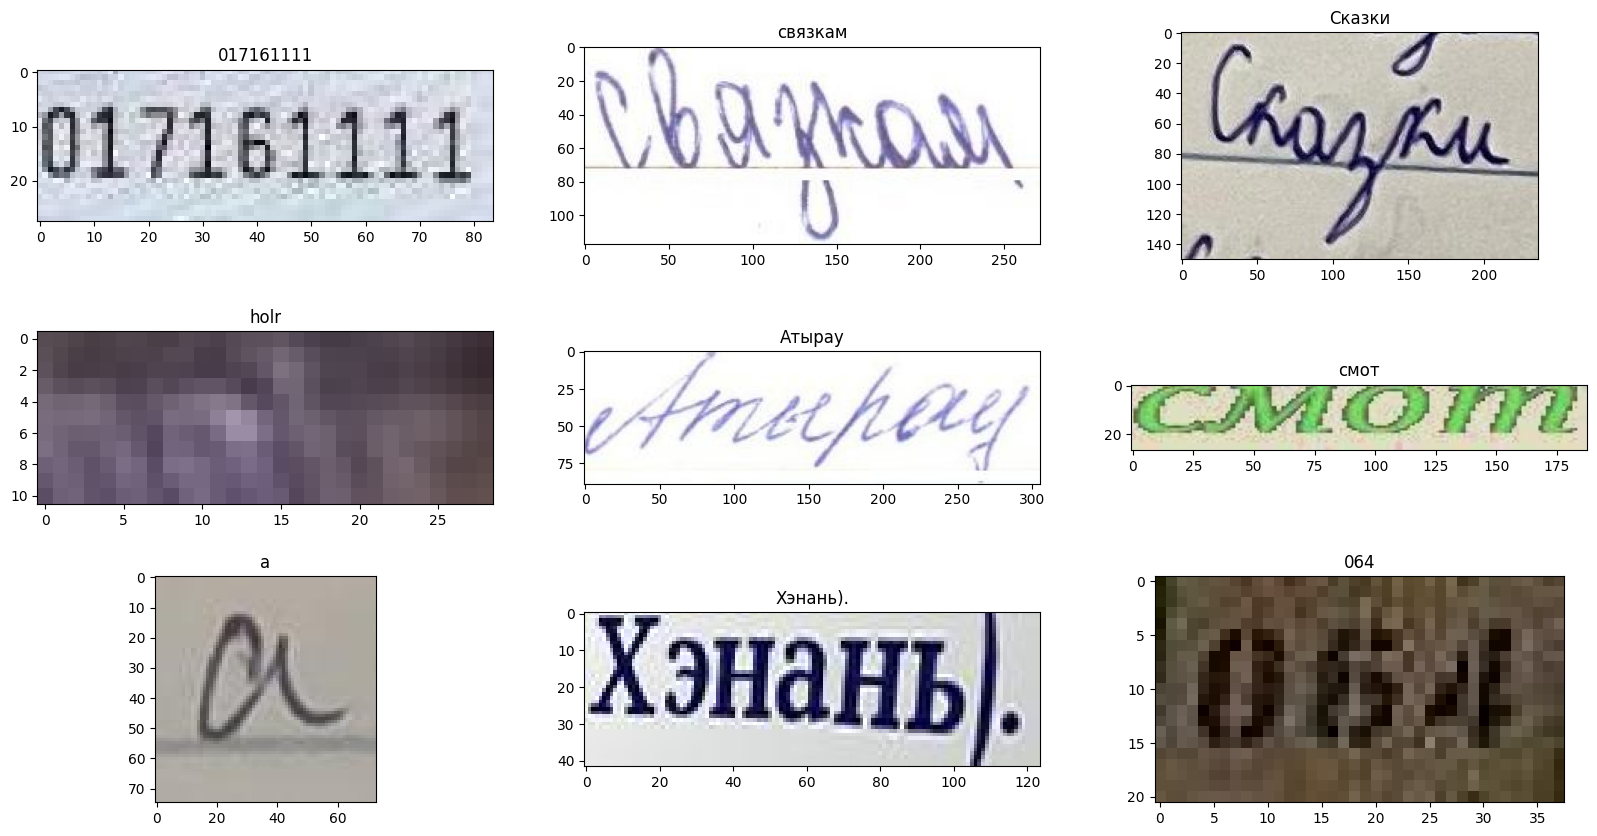

In [4]:
f, ax = plt.subplots(3, 3, figsize=(20, 10))
for idx, row in enumerate(train_df.sample(9, random_state=RANDOM_STATE).itertuples()):
    with Image.open(f'dataset/train/train/{row.Id}') as im:
        ax[idx // 3, idx % 3].imshow(im)
        ax[idx // 3, idx % 3].set_title(row.Expected)
plt.show()

In [5]:
train_df['length'] = train_df['Expected'].apply(lambda x: len(str(x)))

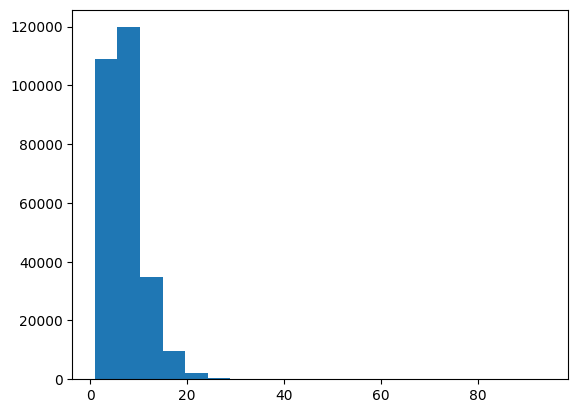

In [6]:
plt.hist(data=train_df, x="length", bins=20)
plt.show()

In [7]:
print(f'More than 30: {round((train_df["length"] > 30).sum() / len(train_df) * 100, 2)}%')

More than 30: 0.23%


In [8]:
russian = "абвгдеёжзиклмнопрстуфхцчшщъыьэюя"
english = "abcdefghijklmnopqrstuvwxyz"

In [9]:
def detect_language(text):
    if any(c.isalpha() for c in str(text)):
        if any(c.lower() in russian for c in str(text)):
            return "russian"
        elif any(c.lower() in english for c in str(text)):
            return "english"
        return 'undefined'
    else:
        return 'digits'

In [10]:
train_df['language'] = train_df['Expected'].apply(detect_language)

In [11]:
train_df['language'].value_counts()

russian      171884
english       66505
digits        37388
undefined       223
Name: language, dtype: int64

In [12]:
def get_image_size(x):
    with Image.open(f'dataset/train/train/{x}') as im:
        return im.size

In [13]:
def get_image_shape(shape):
    if shape[0] > shape[1] * 2:
        return 'horizontal rectangle'
    elif shape[1] > shape[0] * 2:
        return 'vertical rectangle'
    else:
        return 'square'

In [14]:
train_df['image_size'] = train_df['Id'].apply(get_image_size)

In [15]:
train_df['image_shape'] = train_df['image_size'].apply(get_image_shape)

In [16]:
train_df['image_shape'].value_counts()

horizontal rectangle    205986
square                   63212
vertical rectangle        6802
Name: image_shape, dtype: int64

In [17]:
image_shape_x = []
image_shape_y = []
for shape in train_df['image_size']:
    image_shape_x.append(shape[0])
    image_shape_y.append(shape[1])

x_avg = int(sum(image_shape_x) / len(image_shape_x))
y_avg = int(sum(image_shape_y) / len(image_shape_y))
print(f'Average image shape: {x_avg}, {y_avg}')

Average image shape: 189, 55


In [18]:
train_df['type'] = train_df["image_shape"] + ' ' + train_df["language"]

In [19]:
train_df['type'].value_counts()

horizontal rectangle russian      148590
horizontal rectangle english       39568
square english                     25677
square russian                     20253
horizontal rectangle digits        17668
square digits                      17219
vertical rectangle russian          3041
vertical rectangle digits           2501
vertical rectangle english          1260
horizontal rectangle undefined       160
square undefined                      63
Name: type, dtype: int64

### Train test split

In [20]:
TRAIN_SIZE = 0.8

In [21]:
train, val_test = train_test_split(
    train_df, 
    stratify=train_df.type, 
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE
)

In [22]:
val, test = train_test_split(
    val_test, 
    stratify=val_test.type, 
    train_size=0.5, 
    random_state=RANDOM_STATE
)

In [23]:
print(f'{len(train)}, {len(val)}, {len(test)}')

220800, 27600, 27600


In [24]:
def calculate_mean_and_std(df):
    to_tensor = ToTensorV2()
    psum = torch.tensor([0.0, 0.0, 0.0])
    psum_sq = torch.tensor([0.0, 0.0, 0.0])
    count = 0
    for image in tqdm(df['Id'], leave=False):
        image = cv2.imread(f'dataset/train/train/{image}').astype(np.float32) / 255.0
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        arr = to_tensor(image=image)["image"]
        psum += arr.sum(axis = [1, 2])
        psum_sq += (arr ** 2).sum(axis = [1, 2])
        count += arr.size()[1] * arr.size()[2]
    total_mean = psum / count
    total_var = (psum_sq / count) - (total_mean ** 2)
    total_std = torch.sqrt(total_var)
    return total_mean, total_std

In [25]:
mean, std = calculate_mean_and_std(train)

  0%|          | 0/220800 [00:00<?, ?it/s]

In [26]:
mean, std

(tensor([0.6298, 0.6280, 0.6386]), tensor([0.2863, 0.2818, 0.2834]))

In [27]:
train.to_csv('dataset/train.csv', index=False)
val.to_csv('dataset/val.csv', index=False)
test.to_csv('dataset/test.csv', index=False)

### Dataset preparation

In [28]:
MAX_TARGET_LEN = 30
MAX_CTC_LEN = MAX_TARGET_LEN * 3
HEIGHT_RESCALE = 100
WIDTH_RESCALE = 300
DROP_UNDEF_LANGUAGE = False
BATCH_SIZE = 512
EPOCHS = 30

In [29]:
def prepare_train_data(df, max_target_length, drop_language):
    filtered = df[df.length <= max_target_length].copy()
    if drop_language:
        return filtered[~filtered.language.eq('undefined')]
    return filtered

In [30]:
train_filtered = prepare_train_data(train, MAX_TARGET_LEN, DROP_UNDEF_LANGUAGE)
train_filtered.shape

(220283, 7)

In [31]:
BLANK_SYMBOL = '∆'

In [32]:
id2char = set() 
for string in train_filtered.Expected:
    id2char.update(set(str(string)))
if BLANK_SYMBOL in id2char:
    raise Exception
else:
    id2char = [BLANK_SYMBOL] + list(id2char)

In [33]:
char2id = {id2char[i]: i for i in range(len(id2char))}

In [34]:
len(id2char)

552

In [35]:
class OCRDataset(Dataset):
    def __init__(self, df, char2id, folder='dataset/train/train', transforms=None):
        self.df = df
        self.image_names = df["Id"].to_list()
        self.texts = df["Expected"].to_list()
        self.transforms = transforms
        self.char2id = char2id
        self.folder = folder
        self._read_images()
        
    def _read_images(self):
        self.images = {}
        for item in range(len(self.texts)):
            image_name = self.image_names[item]
            image = cv2.imread(f'{self.folder}/{image_name}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.images[image_name] = image
            if item % 10_000 == 0:
                print(item)
            
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        image_name = self.image_names[item]
        image = self.images[image_name]
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        text = str(self.texts[item])
        seq = [self.char2id[c] for c in text if c in self.char2id]
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        return output

In [36]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
def make_erode(img, kernel=kernel, *args, **kwargs):
    return cv2.erode(img, kernel, iterations=1)

def make_dilate(img, kernel=kernel, *args, **kwargs):
    return cv2.dilate(img, kernel, iterations=1)

In [37]:
augmentations = A.Compose([A.OneOf([
    # Morphological alterations
    A.OneOf([
        A.Lambda(name='erode', image=make_erode, p=0.2),
        A.Lambda(name='dilate', image=make_dilate, p=0.2),
    ], p=0.9),
    
    #transformations
    A.ShiftScaleRotate(
        shift_limit=0.10, 
        scale_limit=0.15, 
        rotate_limit=10, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=(255,255,255), 
        p=0.5
    ),
    A.ColorJitter(p=0.5),
    
    A.OneOf([
        #add black pixels noise
        A.OneOf([
            A.RandomRain(
                brightness_coefficient=1.0, 
                drop_length=2, 
                drop_width=2, 
                drop_color = (0, 0, 0), 
                blur_value=1, 
                rain_type = 'drizzle', 
                p=0.05
            ),
            A.RandomShadow(p=1),
            A.PixelDropout(p=1),
        ], p=0.9),

        #add white pixels noise
        A.OneOf([
            A.PixelDropout(dropout_prob=0.5, drop_value=255,p=1),
            A.RandomRain(
                brightness_coefficient=1.0, 
                drop_length=2, 
                drop_width=2, 
                drop_color = (255, 255, 255), 
                blur_value=1, 
                rain_type = None, 
                p=1
            ), 
        ], p=0.9),
    ], p=1),
    
    #Blur
    A.GaussianBlur(blur_limit=(3, 7),p=0.25),
    ], p=0.75)
])

In [38]:
train_transform = A.Compose(
    [
        A.Resize(height=HEIGHT_RESCALE, width=WIDTH_RESCALE),
        augmentations,
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [
        A.Resize(height=HEIGHT_RESCALE, width=WIDTH_RESCALE),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ]
)

In [39]:
train_dataset = OCRDataset(train_filtered, char2id, transforms=train_transform)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000


In [40]:
val_dataset = OCRDataset(val, char2id, transforms=train_transform)
test_dataset = OCRDataset(test, char2id, transforms=train_transform)

0
10000
20000
0
10000
20000


In [41]:
def collate_fn(batch):
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(item["image"])
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [42]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE, shuffle=True, num_workers=12, pin_memory=True, 
                              drop_last=True, collate_fn=collate_fn)

val_dataloader = DataLoader(val_dataset,
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True, 
                              drop_last=False, collate_fn=collate_fn)

test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True, 
                              drop_last=False, collate_fn=collate_fn)

### ResNet 18

In [43]:
from transformers import AutoFeatureExtractor, ResNetForImageClassification

In [44]:
class FeatureGenerator(nn.Module):
    def __init__(self, input_size=(HEIGHT_RESCALE, WIDTH_RESCALE), output_len=MAX_CTC_LEN):
        super(FeatureGenerator, self).__init__()
        h, w = input_size
        model = ResNetForImageClassification.from_pretrained("./resnet-18")
        self.resnet = nn.Sequential(*list(model.resnet.children())[:-1])
        self.pool = nn.AdaptiveAvgPool2d((1, 10))  
        self.conv = nn.Conv2d(10, MAX_CTC_LEN, kernel_size=1)
    
    def forward(self, x):
        features = self.resnet(x)
        features = self.pool(features['last_hidden_state'])
        
        features = features.permute(0, 3, 2, 1).contiguous()
        features = self.conv(features)
        features = features.permute(0, 2, 3, 1).contiguous()
        
        return features

In [45]:
class SeqPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SeqPredictor, self).__init__()

        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=bidirectional
        )
        in_feats = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(in_feats, num_classes)
        
    def _init_hidden(self, batch_size):
        num_directions = 2 if self.rnn.bidirectional else 1
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        return h
        
    def forward(self, x):
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        
        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, _ = self.rnn(x, h_0)
        
        x = self.fc(x)
        return x

In [46]:
class FirstNN(nn.Module):
    def __init__(self, num_classes=len(id2char), cnn_input_size=(HEIGHT_RESCALE, WIDTH_RESCALE),
                 cnn_output_len=MAX_CTC_LEN, rnn_hid_size=128, rnn_num_layers=2, 
                 rnn_dropout=0.3, rnn_bidirectional=False):
        super(FirstNN, self).__init__()
        
        self.fe = FeatureGenerator(input_size=cnn_input_size, output_len=cnn_output_len)
        self.pred = SeqPredictor(input_size=512, hidden_size=rnn_hid_size, num_layers=rnn_num_layers,
                                 num_classes=num_classes, dropout=rnn_dropout, bidirectional=rnn_bidirectional)
        
    def forward(self, x):
        features = self.fe(x)
        seq = self.pred(features)
        return seq

In [47]:
test_model = FirstNN()

In [48]:
test_model(torch.randn(size=(10, 3, HEIGHT_RESCALE, WIDTH_RESCALE))).shape

torch.Size([90, 10, 552])

In [49]:
def pred_to_string(pred, id2char, blank_id=0):
    seq = []
    for i in range(len(pred)):
        seq.append(np.argmax(pred[i]))
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != blank_id:
                out.append(seq[i])
        else:
            if seq[i] != blank_id and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([id2char[c] for c in out])
    return out

In [50]:
def decode(pred, id2char):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], id2char))
    return outputs

In [51]:
class ResNetExperiment(pl.LightningModule):
    def __init__(self, id2char):
        super().__init__()
        self.model = FirstNN()
        self.id2char = id2char
        
        self.loss_fn = nn.CTCLoss()
        self.lr = 0.01
        
    def forward(self, x):
        return self.model(x)
    
    def step(self, batch, batch_idx, stage):
        logits = self.forward(batch['image']).cpu()
        log_probs = log_softmax(logits, dim=2)
        seq_lens_pred = torch.Tensor([logits.size(0)] * logits.size(1)).int()
        loss = self.loss_fn(
            log_probs=log_probs,
            targets=batch['seq'].cpu(),
            input_lengths=seq_lens_pred,
            target_lengths=batch['seq_len'].cpu()
        )
        self.log(f'{stage}_loss', loss, on_epoch=True, on_step=stage=='train', prog_bar=True)
        metric = self.get_mean_distance(logits, batch['text'])
        self.log(f'{stage}_metric', metric, on_epoch=True,  on_step=False, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "test")
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        logits = self.forward(batch['image']).cpu()
        texts_preds = decode(logits, self.id2char)
        return texts_preds
    
    def get_mean_distance(self, logits, texts):
        texts_preds = decode(logits, self.id2char)
        res = 0
        for text_pred, text_real in zip(texts_preds, texts):
            res += edit_distance(text_pred, text_real)
        return res / len(texts_preds)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=0.25,
            epochs=EPOCHS,
            steps_per_epoch=len(train_filtered) // BATCH_SIZE
        )

        return [optimizer], [scheduler]

In [52]:
model = ResNetExperiment(id2char)

In [53]:
logger = pl.loggers.TensorBoardLogger(save_dir='./logs', version="resnet-18-new")

In [54]:
early_stopping = EarlyStopping(monitor="val_metric", mode="min", patience=3)

In [72]:
trainer = pl.Trainer(max_epochs=40, accelerator="gpu", devices=1, logger=logger, callbacks=[early_stopping])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [73]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/data/home/makhisamu1/1_CV_CONTEST/cv_contest/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning:

Checkpoint directory ./logs/lightning_logs/resnet-18-new/checkpoints exists and is not empty.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type    | Params
------------------------------------
0 | model   | FirstNN | 11.6 M
1 | loss_fn | CTCLoss | 0     
------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.377    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [77]:
new_model = ResNetExperiment(id2char)

In [79]:
new_model.load_from_checkpoint('logs/lightning_logs/resnet-18-new/checkpoints/epoch=29-step=12900.ckpt', id2char=id2char)

ResNetExperiment(
  (model): FirstNN(
    (fe): FeatureGenerator(
      (resnet): Sequential(
        (0): ResNetEmbeddings(
          (embedder): ResNetConvLayer(
            (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (activation): ReLU()
          )
          (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        )
        (1): ResNetEncoder(
          (stages): ModuleList(
            (0): ResNetStage(
              (layers): Sequential(
                (0): ResNetBasicLayer(
                  (shortcut): Identity()
                  (layer): Sequential(
                    (0): ResNetConvLayer(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momen

In [81]:
trainer.model = new_model

In [82]:
trainer.test(dataloaders=test_dataloader)

/data/home/makhisamu1/1_CV_CONTEST/cv_contest/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.

Restoring states from the checkpoint path at ./logs/lightning_logs/resnet-18-new/checkpoints/epoch=10-step=4730.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at ./logs/lightning_logs/resnet-18-new/checkpoints/epoch=10-step=4730.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.316060185432434
       test_metric          2.3236594200134277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.316060185432434, 'test_metric': 2.3236594200134277}]

In [83]:
import os

pred_df = pd.DataFrame({
    'Id': os.listdir('./dataset/test/test/'),
    'Expected': ['text'] * len(os.listdir('./dataset/test/test/'))
})

In [84]:
pred_dataset = OCRDataset(pred_df, char2id, folder='./dataset/test/test', transforms=val_transform)

0
10000
20000
30000
40000
50000


In [85]:
pred_dataloader = DataLoader(pred_dataset,
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=12, pin_memory=True, 
                          drop_last=False, collate_fn=collate_fn)

In [86]:
prediction = trainer.predict(dataloaders=pred_dataloader)

/data/home/makhisamu1/1_CV_CONTEST/cv_contest/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning:

`.predict(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `predict(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.

Restoring states from the checkpoint path at ./logs/lightning_logs/resnet-18-new/checkpoints/epoch=10-step=4730.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from checkpoint at ./logs/lightning_logs/resnet-18-new/checkpoints/epoch=10-step=4730.ckpt


Predicting: 430it [00:00, ?it/s]

In [87]:
prediction = pd.DataFrame(
    {
        'Id': pred_df['Id'],
        'Predicted': [item for sublist in prediction for item in sublist]
    }
)

In [88]:
prediction.to_csv('pred_resnet18_v3.csv', index=False)

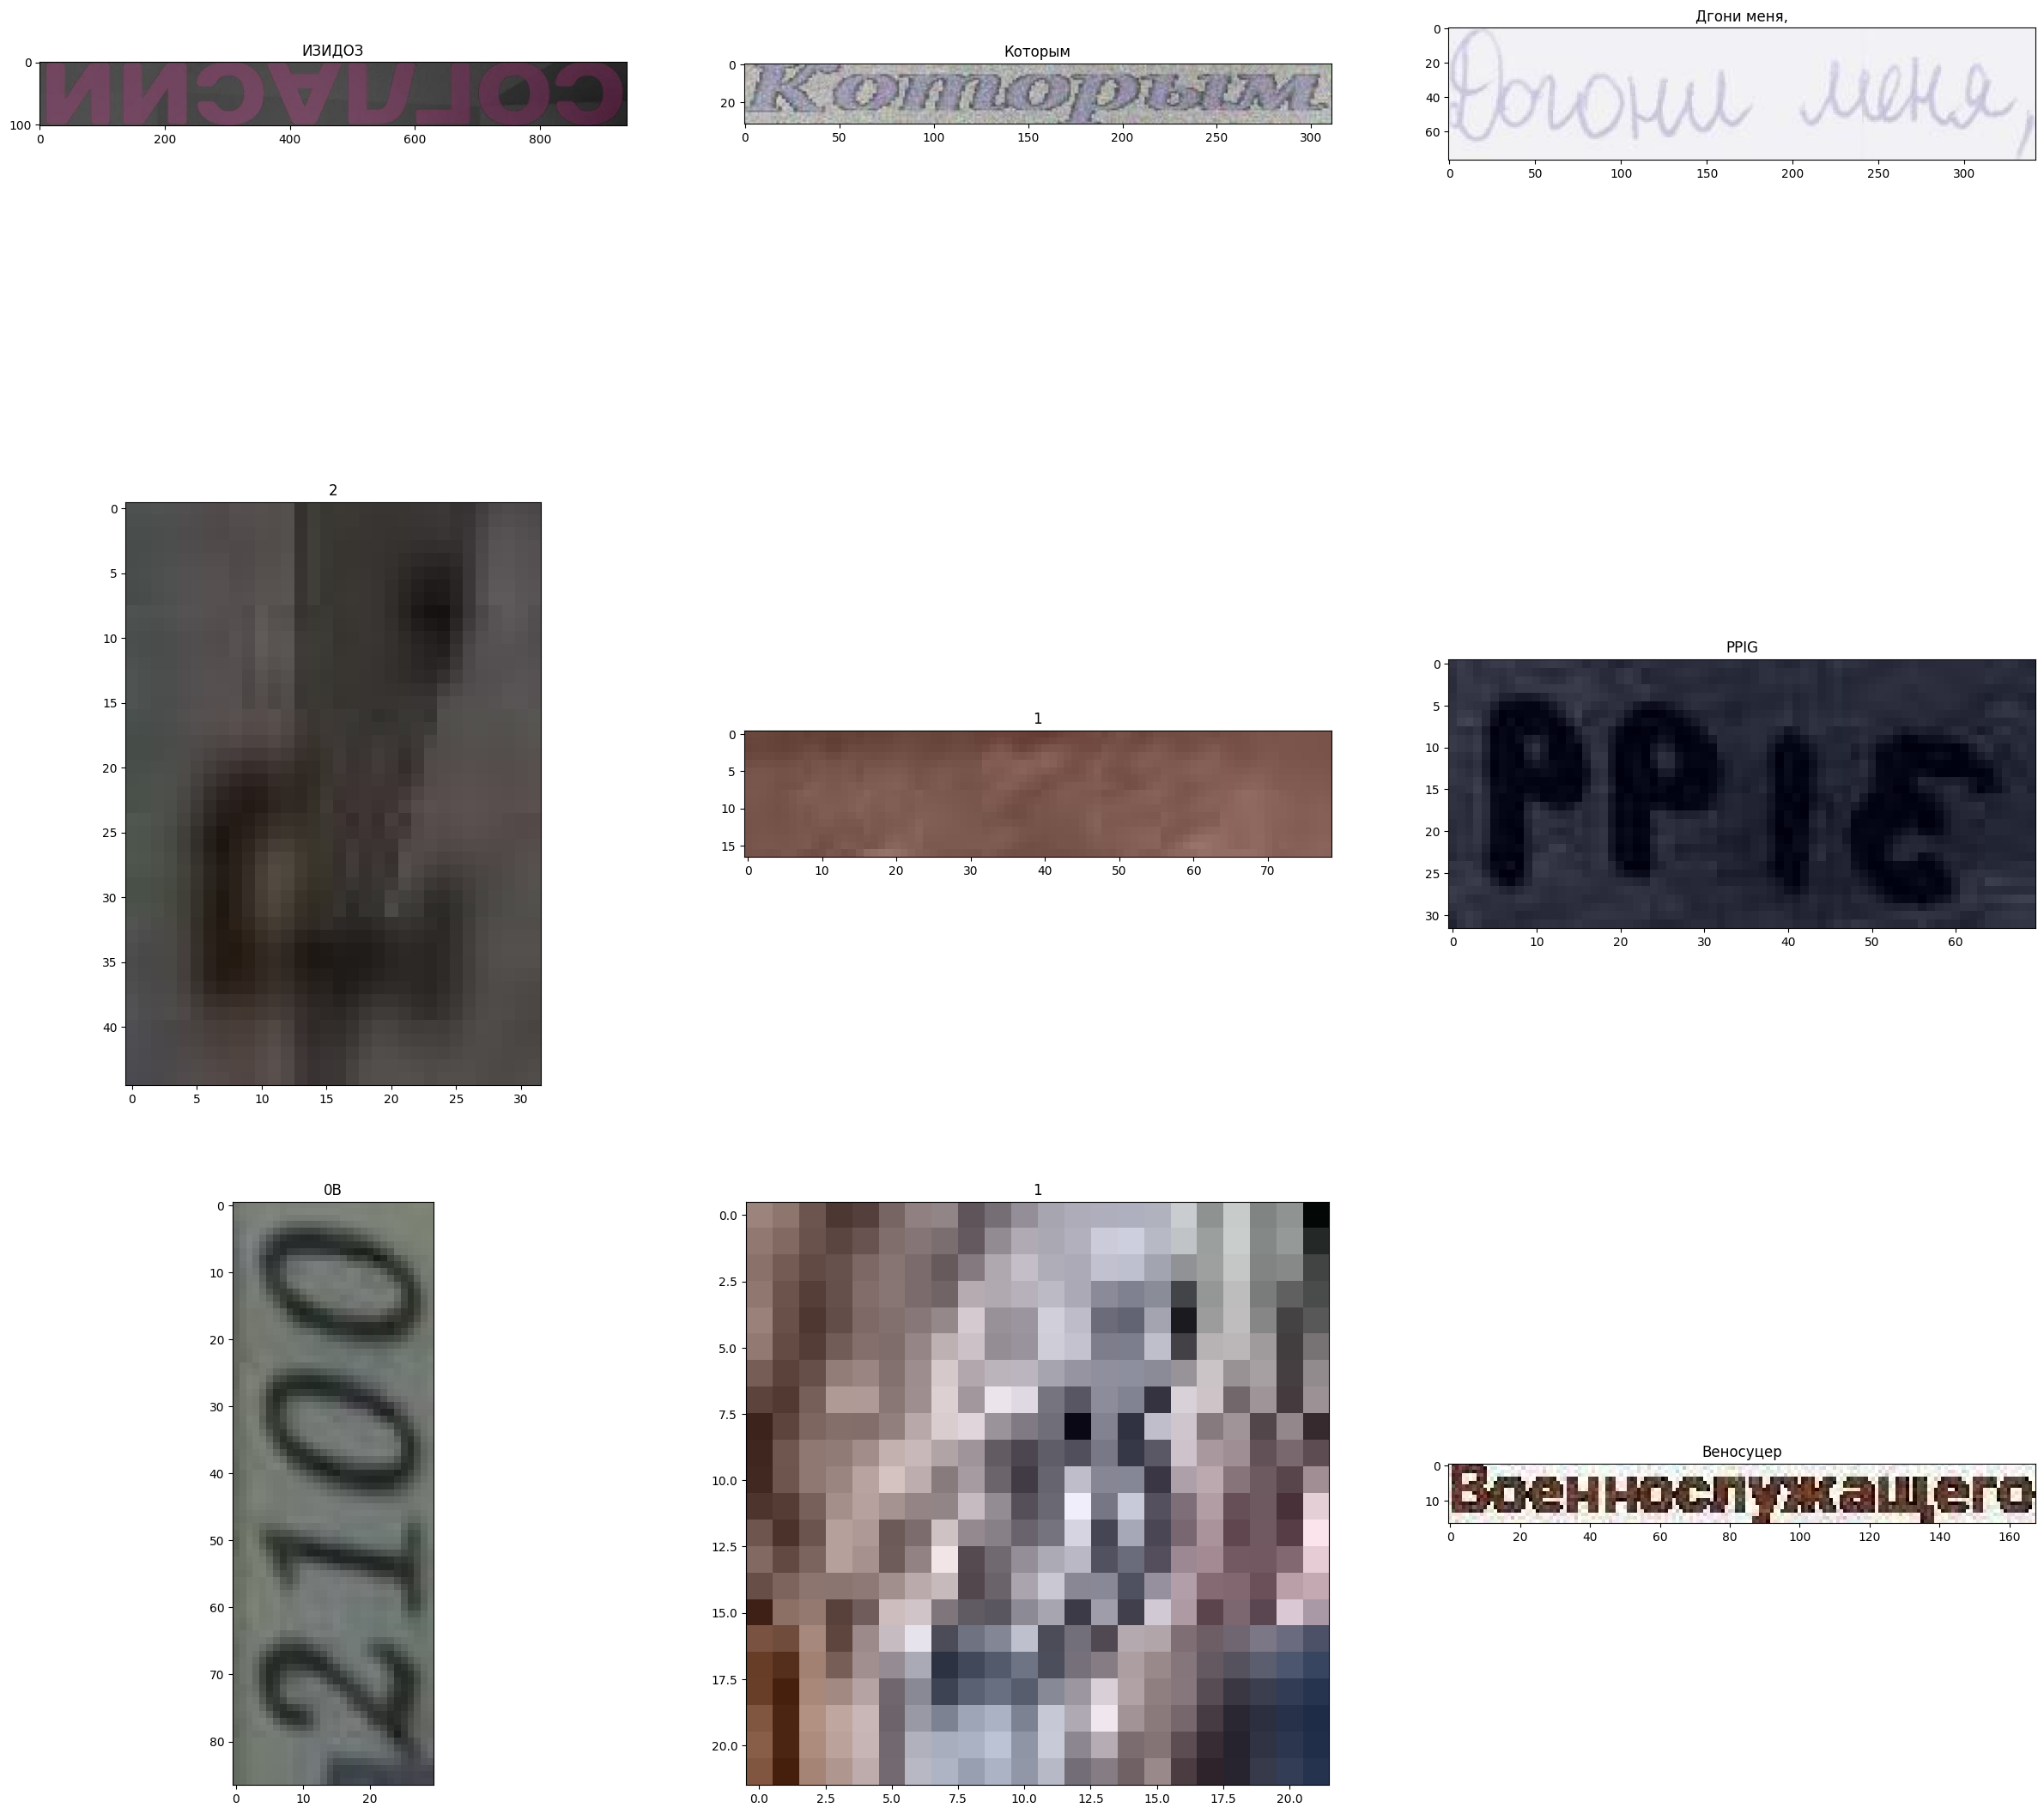

In [89]:
f, ax = plt.subplots(3, 3, figsize=(30, 30))
for idx, row in enumerate(prediction.sample(9, random_state=737).itertuples()):
    with Image.open(f'dataset/test/test/{row.Id}') as im:
        ax[idx // 3, idx % 3].imshow(im)
        ax[idx // 3, idx % 3].set_title(row.Predicted)
plt.show()